Loading the trained BPNet model...
Model loaded successfully.
Loading validation data...
Validation data loaded. Shape: (57882,)
One-hot encoding validation data...
One-hot encoded validation data. Shape: (57882, 18593, 4)


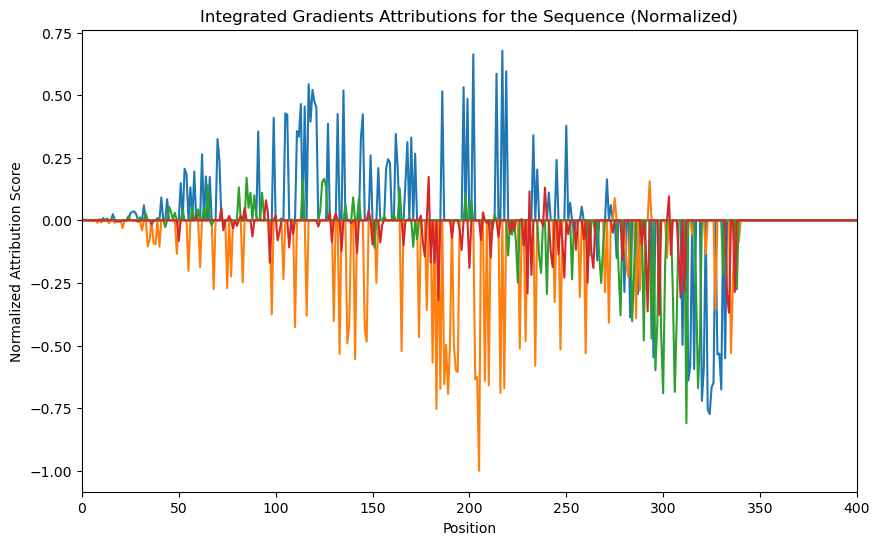

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the trained BPNet model
print("Loading the trained BPNet model...")
model = tf.keras.models.load_model('../results/model/bpnet_model.keras')
print("Model loaded successfully.")

# Define the one-hot encoding function
def one_hot_encode(sequence, max_len):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'a': 0, 'c': 1, 'g': 2, 't': 3}
    one_hot = np.zeros((max_len, 4), dtype=np.int8)
    for i, char in enumerate(sequence[:max_len]):
        if char in mapping:
            one_hot[i, mapping[char]] = 1
    return one_hot

# Load validation data
print("Loading validation data...")
X_val = np.load('../data/processed/X.npy', allow_pickle=True)  # Ensure to use the correct file path
print(f"Validation data loaded. Shape: {X_val.shape}")

# Define the maximum sequence length
max_len = 18593

# One-hot encode validation data
print("One-hot encoding validation data...")
X_val_encoded = np.array([one_hot_encode(seq, max_len) for seq in X_val])
print(f"One-hot encoded validation data. Shape: {X_val_encoded.shape}")

# Define Integrated Gradients function compatible with TensorFlow 2.x
@tf.function
def compute_gradients(inputs, model):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
    grads = tape.gradient(predictions, inputs)
    return grads

def integrated_gradients(inputs, baseline, model, steps=50):
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(steps + 1)]
    avg_grads = np.mean([compute_gradients(tf.convert_to_tensor(x, dtype=tf.float32), model).numpy() for x in scaled_inputs], axis=0)
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

# Prepare baseline (zero array of same shape as input)
baseline = np.zeros((max_len, 4), dtype=np.float32)

# Example usage with one sequence
input_sequence = X_val_encoded[0].astype(np.float32)  # Ensure dtype is float32
input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension
target_class_idx = 0  # Modify based on your target class
attributions = integrated_gradients(input_sequence, baseline, model)

# Normalize attributions
norm_attributions = attributions[0] / np.max(np.abs(attributions[0]))

# Visualize the normalized attributions
plt.figure(figsize=(10, 6))
plt.plot(norm_attributions)  # Remove batch dimension for plotting
plt.title('Integrated Gradients Attributions for the Sequence (Normalized)')
plt.xlabel('Position')
plt.ylabel('Normalized Attribution Score')
plt.xlim(0, 400)  #zoom in
plt.show()
